In [120]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astroquery.vizier import Vizier
from tools import *

from dustmaps.bayestar import BayestarQuery

In [12]:
def Get_Catalogue(ra,dec,rad, Catalog = 'gaia'):
    """
    Get the coordinates and mag of all sources in the field of view from a specified catalogue.


    I/347/gaia2dis   Distances to 1.33 billion stars in Gaia DR2 (Bailer-Jones+, 2018)

    -------
    Inputs-
    -------
        tpf 				class 	target pixel file lightkurve class
        Catalogue 			str 	Permitted options: 'gaia', 'dist', 'ps1'

    --------
    Outputs-
    --------
        coords 	array	coordinates of sources
        Gmag 	array 	Gmags of sources
    """
    c1 = SkyCoord(ra, dec, frame='icrs', unit='deg')

    Vizier.ROW_LIMIT = -1
    if Catalog == 'gaia':
        catalog = "I/345/gaia2"
    elif Catalog == 'dist':
        catalog = "I/347/gaia2dis"
    elif Catalog == 'ps1':
        catalog = "II/349/ps1"
    elif Catalog == 'skymapper':
        catalog = 'II/358/smss'
    else:
        raise ValueError("{} not recognised as a catalog. Available options: 'gaia', 'dist','ps1'")

    result = Vizier.query_region(c1, catalog=[catalog],
                                 radius=Angle(rad, "deg"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise no_targets_found_message
    result = result[catalog].to_pandas()

    return result 

In [13]:
ra = 89.85051
dec = 71.65306

In [166]:
ps1 = Get_Catalogue(ra,dec,.2,'ps1')
dist = Get_Catalogue(ra,dec,.2,'dist')

d = np.sqrt((ps1.RAJ2000.values[:,np.newaxis] - dist.RA_ICRS.values[np.newaxis,:])**2 - (ps1.DEJ2000.values[:,np.newaxis] - dist.DE_ICRS.values[np.newaxis,:])**2)
d[d >= (1/60**2) * 3] = np.nan#10000
mins = np.nanmin(d,axis=1)

ps1_ind,gaia_ind = np.where(d==np.ones_like(d)*mins[:,np.newaxis])
data = ps1.iloc[ps1_ind]
data['dist'] = dist.iloc[gaia_ind]['rest'].values
data = data.rename(columns={'gmag':'gMeanPSFMag','rmag':'rMeanPSFMag','imag':'iMeanPSFMag',
                    'e_gmag':'gMeanPSFMagErr','e_rmag':'rMeanPSFMagErr','e_imag':'iMeanPSFMagErr'})

In [104]:
bayestar = BayestarQuery(max_samples=1)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 15.556 s
  pix_info:   0.434 s
   samples:   4.701 s
      best:   4.402 s
       nan:   0.023 s
      sort:   5.825 s
       idx:   0.171 s


In [143]:
coords = SkyCoord(ra=data.RAJ2000.values*u.deg,dec=data.DEJ2000.values*u.deg,distance=data.dist.values*u.pc)

In [167]:
b19 = bayestar(coords, mode='median')
data['b19'] = b19

<IPython.core.display.Javascript object>


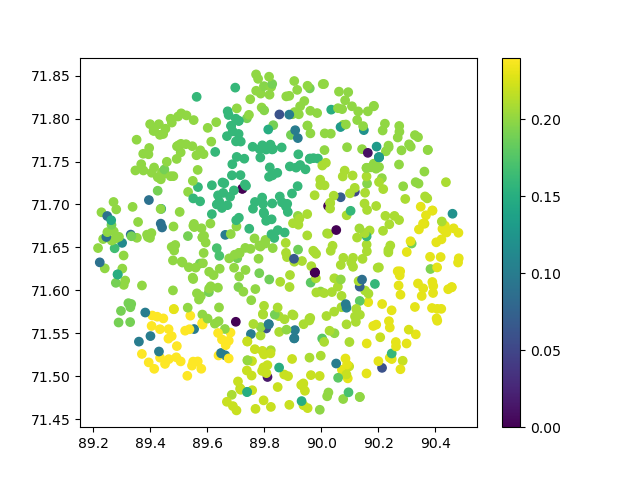

In [170]:
plt.figure()
plt.scatter(data.RAJ2000.values,data.DEJ2000.values,c = b19)
plt.colorbar()

<IPython.core.display.Javascript object>


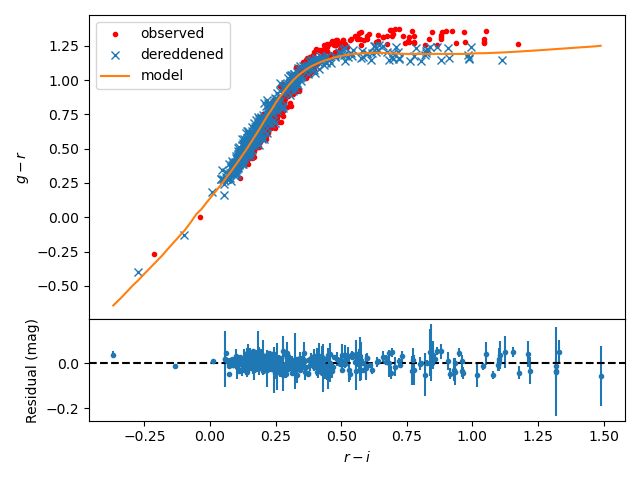

In [171]:
slr, dat = Tonry_reduce(data,plot=True)

In [147]:
plt.text()

array([0.12347345])

In [149]:
np.nanmedian(ebv)

0.19999999

In [150]:
compare = ['r-i','g-r']

<IPython.core.display.Javascript object>


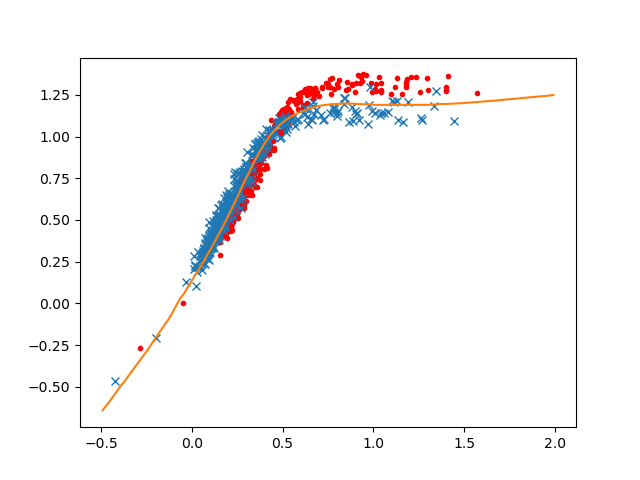

In [172]:
tonry = np.loadtxt('Tonry_splines.txt')
compare = np.array([['r-i','g-r']])   
colours = Make_colours(dat,tonry,compare,Extinction = dat['b19'], Tonry = True,B19=True)
rawc = Make_colours(dat,tonry,compare,Extinction = 0, Tonry = True)
dist = Calculate_distance(np.array([colours['obs r-i'][0],colours['obs g-r'][0]]), np.array([tonry[:,0],tonry[:,1]]))
plt.figure()
plt.plot(rawc['obs r-i'][0],rawc['obs g-r'][0],'r.',label='observed')
plt.plot(colours['obs r-i'][0],colours['obs g-r'][0],'x',label='dereddened')
plt.plot(colours['mod r-i'],colours['mod g-r'],label='model')

In [153]:
colours

{'obs r-i': array([[0.14571028, 0.20808   , 0.99078   , ..., 0.1276    , 0.7313    ,
         0.23096094],
        [0.0025    , 0.02344014, 0.01396173, ..., 0.01421443, 0.12877828,
         0.04562455]]),
 'obs g-r': array([[0.45681171, 0.49698   , 1.15378   , ..., 0.3977    ,        nan,
         0.77600343],
        [0.00282843, 0.01931036, 0.04984506, ..., 0.02802231,        nan,
         0.06696058]]),
 'mod r-i': array([-0.49237805, -0.49137805, -0.49037805, ...,  1.99062195,
         1.99162195,  1.99262195]),
 'mod g-r': array([-0.64200074, -0.64063652, -0.63927231, ...,  1.24930105,
         1.24946754,  1.24963404])}

In [31]:
ind = np.argmin(d,axis=1)

far = d <= (1/60**2) * 1 # difference smaller than 1 arcsec
# Get index of all valid matches and add the Gaia info
indo = np.nansum(far,axis=1) > 0
ind = ind[indo]

In [58]:
mins[np.newaxis,:]

array([[0.00263547, 0.00794113, 0.00962809, ..., 0.00802648, 0.0090046 ,
        0.00363191]])

In [64]:
d - mins[:,np.newaxis]

array([[1.91426123e-01, 2.57126592e-02, 2.43158072e-02, ...,
        9.99999736e+03, 9.99999736e+03, 9.99999736e+03],
       [8.06633880e-03, 1.74123973e-01, 1.75550248e-01, ...,
        9.99999206e+03, 9.99999206e+03, 9.99999206e+03],
       [9.99999037e+03, 1.56071726e-01, 1.57458506e-01, ...,
        9.99999037e+03, 9.99999037e+03, 9.99999037e+03],
       ...,
       [9.99999197e+03, 9.99999197e+03, 9.99999197e+03, ...,
        0.00000000e+00, 3.63380969e-03, 5.61518691e-03],
       [9.99999100e+03, 9.99999100e+03, 9.99999100e+03, ...,
        2.56795083e-02, 2.93067474e-02, 3.13868909e-02],
       [9.99999637e+03, 9.99999637e+03, 9.99999637e+03, ...,
        9.99999637e+03, 0.00000000e+00, 1.92691103e-03]])

In [57]:
d == mins[np.newaxis,:]


/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [30]:
ind.shape

(6889,)

In [41]:
data = ps1.iloc[ind]
data['dist'] = np.nan
data['dist'] = dist['rest'].values[indo]

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2619 but corresponding boolean dimension is 6889

In [47]:
len(ind)

1345

In [45]:
len(indo)

6889

In [33]:
dist

,Source,RA_ICRS,DE_ICRS,rest,b_rest,B_rest,rlen,ResFlag,ModFlag
0,486088008966592384,89.773322,71.365959,4198.558402,3527.949456,5089.446726,548.379267,1,1
1,486088185061927552,89.939035,71.363707,890.129800,503.000039,1778.988372,547.053719,1,1
2,486088185061955584,89.940460,71.361729,1353.177805,771.542964,2351.906553,547.059832,1,1
3,486088215125019776,89.963528,71.365170,3757.389147,2892.059138,4933.902897,546.842523,1,1
4,486088215125023616,89.977367,71.370533,2637.977223,2147.946612,3338.139864,546.682945,1,1
...,...,...,...,...,...,...,...,...,...
2614,1107849606703942400,90.056726,71.929060,1278.921031,1182.599222,1391.764069,541.257014,1,1
2615,1107849636766321024,90.105748,71.936291,1038.278661,758.941497,1560.292927,540.819064,1,1
2616,1107849641062262144,90.090519,71.930618,1255.379228,749.275755,2185.933965,540.983207,1,1
2617,1107849641062262272,90.094313,71.929505,341.574338,198.805633,1022.126203,540.963113,1,1


In [26]:
dist.shape

(2619, 9)